<a href="https://colab.research.google.com/github/somkumarsahoo/MachineLearningFundamentals/blob/main/extract_line_sketch_from_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [230]:
!pip install svgwrite

In [231]:
!pip install svglib reportlab cairosvg pillow

In [232]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from skimage.segmentation import slic, mark_boundaries, watershed
from skimage.filters import sobel
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from scipy.spatial import KDTree
from PIL import Image
import svgwrite
import xml.etree.ElementTree as ET

import pdb


from google.colab.patches import cv2_imshow

import cv2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score,pairwise_distances

from sklearn.metrics import pairwise_distances

In [233]:
def load_image(image_path):
    """
    Load image from file.

    Args:
    image_path (str): Image file path.

    Returns:
    numpy array: Loaded image.
    """
    image = cv2.imread(image_path)

    if image is None:
        print(f"Error loading image: {image_path}")
        return None

    return image


In [234]:
def resize_image(image, max_size=1024):
    """
    Resize image to reduce memory usage.

    Args:
    image (numpy array): Input image.
    max_size (int): Maximum image size.

    Returns:
    numpy array: Resized image.
    """
    try:
        height, width, _ = image.shape

        # Calculate scaling factor
        scale = min(max_size / height, max_size / width)

        # Resize image
        resized_image = cv2.resize(image, (int(width * scale), int(height * scale)))

        return resized_image

    except Exception as e:
        print(f"Error resizing image: {e}")
        return None


In [235]:
def refine_contours(contours, threshold=5):
    refined_contours = []
    for contour in contours:
        contour = np.array(contour)
        # Remove duplicate points
        contour = np.unique(contour, axis=0)

        merged_points = [contour[0][0]]  # Start with the first point
        for i in range(1, len(contour)):
            found_merge = False
            for j in range(i+1, len(contour)):
                dist = np.linalg.norm(contour[i][0] - contour[j][0])
                if dist < threshold:
                    # Check if points are on the same line
                    vec1 = contour[i-1][0] - contour[i][0]
                    vec2 = contour[j-1][0] - contour[j][0]
                    if np.abs(np.cross(vec1, vec2)).sum() < 0.1:
                        # Merge points
                        midpoint = (contour[i][0] + contour[j][0]) // 2
                        merged_points.append(midpoint)
                        found_merge = True
                        break
            if not found_merge:
                merged_points.append(contour[i][0])
        # Close the contour
        merged_points.append(merged_points[0])
        refined_contours.append(np.array([merged_points]))

    return refined_contours

In [236]:
def gaussian_blur(image, kernel_size=(3, 3), sigma=0):
    """
    Apply Gaussian blur to an image.

    Parameters:
    image (numpy array): Input image.
    kernel_size (tuple): Kernel size.
    sigma (int): Standard deviation.

    Returns:
    numpy array: Blurred image.
    """
    blurred_image = cv2.GaussianBlur(image, kernel_size, sigma)
    return blurred_image

In [237]:
def determine_optimal_k(image, max_k=50, threshold=0.1):
    """
    Determine optimal number of clusters using Silhouette Score and Calinski-Harabasz Index.

    Parameters:
    image (numpy array): Input image.
    max_k (int): Maximum number of clusters.
    threshold (float): Minimum score threshold.

    Returns:
    int: Optimal number of clusters.
    """
    image_reshaped = image.reshape(-1, 3)
    optimal_k = 0
    max_silhouette = -1
    max_calinski = -1

    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(image_reshaped)
        labels = kmeans.labels_
        silhouette = silhouette_score(image_reshaped, labels)
        calinski = calinski_harabasz_score(image_reshaped, labels)

        if silhouette > max_silhouette and calinski > max_calinski and silhouette > threshold:
            max_silhouette = silhouette
            max_calinski = calinski
            optimal_k = k

    return optimal_k

In [238]:
def kmeans_clustering(image, optimal_k=20):
    """
    Apply K-Means clustering to an image.

    Parameters:
    image (numpy array): Input image.
    optimal_k (int): Number of clusters.

    Returns:
    numpy array: Cluster labels.
    """
    image_reshaped = image.reshape(-1, 3)
    kmeans = KMeans(n_clusters=optimal_k)
    kmeans.fit(image_reshaped)
    labels = kmeans.labels_
    return labels


In [239]:
def identify_parallel_lines(close_points, threshold_slope=0.1, threshold_dist=1):
    """
    Identify parallel lines corresponding to neighboring color segments.

    Args:
        close_points (dict): Points to analyze.
        threshold_slope (float, optional): Maximum slope difference. Defaults to 0.1.
        threshold_dist (int, optional): Maximum distance between parallel lines. Defaults to 1.

    Returns:
        dict: Identified parallel lines.
    """

    if not isinstance(close_points, dict):
        raise ValueError("Input must be a dictionary")

    parallel_lines = {}

    # Check if close_points is empty
    if not close_points:
        return parallel_lines

    # Iterate through close_points
    for pair, points in close_points.items():
        # Handle single-point case
        if len(points) < 2:
            continue

        # Calculate slope and distance for each pair of points
        for i in range(len(points)):
            for j in range(i + 1, len(points)):
                point1 = points[i]
                point2 = points[j]

                try:
                    # Calculate slope manually
                    dx = point2[0] - point1[0]
                    dy = point2[1] - point1[1]

                    # Check for zero distance
                    if dx == 0 and dy == 0:
                        continue

                    # Check for vertical line
                    if dx == 0:
                        slope = float('inf')
                    else:
                        slope = dy / dx

                    # Calculate distance
                    dist = np.linalg.norm(np.array([dx, dy]))

                    # Check conditions using numpy's all() function
                    if np.all([abs(slope) <= threshold_slope]) and dist <= threshold_dist:
                        # Add to parallel_lines dictionary
                        if pair not in parallel_lines:
                            parallel_lines[pair] = []
                        parallel_lines[pair].append((point1, point2))
                except ZeroDivisionError:
                    # Handle division by zero
                    continue
                except Exception as e:
                    # Handle other exceptions
                    print(f"Error: {e}")
                    continue

        # Break loop if parallel_lines is not empty
        if parallel_lines:
            break

    return parallel_lines

In [240]:
def create_segmented_images(image, labels, optimal_k=20):
    """
    Create segmented images based on K-Means clustering.

    Parameters:
    image (numpy array): Input image.
    labels (numpy array): Cluster labels.
    optimal_k (int): Number of clusters.

    Returns:
    list: List of segmented images.
    """
    segmented_images = []
    for i in range(optimal_k):
        cluster_mask = labels == i
        cluster_image = np.zeros_like(image)
        cluster_image[cluster_mask.reshape(image.shape[:2]), :] = image[cluster_mask.reshape(image.shape[:2]), :]
        segmented_images.append(cluster_image)
    return segmented_images


In [241]:
def canny_edge_detection(image, threshold1=100, threshold2=200):
    """
    Apply Canny edge detection to an image.

    Parameters:
    image (numpy array): Input image.
    threshold1 (int): Lower threshold.
    threshold2 (int): Upper threshold.

    Returns:
    numpy array: Edge map.
    """
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    canny_image = cv2.Canny(gray_image, threshold1, threshold2)
    return canny_image

In [242]:
def contour_detection(image, contour_threshold=50, area_threshold=500):
    """
    Detect contours in an image.

    Parameters:
    image (numpy array): Input image.
    contour_threshold (int): Contour length threshold.
    area_threshold (int): Contour area threshold.

    Returns:
    list: List of contours.
    """
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    contours, _ = cv2.findContours(gray_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    filtered_contours = []
    for contour in contours:
        contour_length = cv2.arcLength(contour, True)
        contour_area = cv2.contourArea(contour)
        if contour_length > contour_threshold and contour_area > area_threshold:
            filtered_contours.append(contour)
    return filtered_contours


In [243]:
def find_close_points(contours, threshold=5):
    """
    Find pairwise close points between contours.

    Parameters:
    contours (list): List of contours.
    threshold (int): Distance threshold.

    Returns:
    dict: Dictionary of close points.
    """
    close_points = {}
    for i in range(len(contours)):
        for j in range(i+1, len(contours)):
            close_points[(i, j)] = []
            for point1 in contours[i]:
                for point2 in contours[j]:
                    dist = np.linalg.norm(point1 - point2)
                    if dist < threshold:
                        close_points[(i, j)].append((point1, point2))
    return close_points


In [244]:
def remove_internal_double_lines(parallel_lines, contours):
    """
    Remove internal double lines from contours.

    Parameters:
    parallel_lines (dict): Dictionary of parallel lines.
    contours (list): List of contours.

    Returns:
    list: List of refined contours.
    """
    for pair, lines in parallel_lines.items():
        contour1, contour2 = contours[pair[0]], contours[pair[1]]
        for line in lines:
            point1, point2 = line
            contour1 = np.delete(contour1, np.where(np.all(contour1 == point1, axis=1)), axis=0)
            contour2 = np.delete(contour2, np.where(np.all(contour2 == point2, axis=1)), axis=0)
        contours[pair[0]] = contour1
        contours[pair[1]] = contour2
    return contours


In [245]:
def draw_contours(image, contours, color=(255, 255, 255), thickness=1):
    """
    Draw contours on an image.

    Parameters:
    image (numpy array): Input image.
    contours (list): List of contours.
    color (tuple): Contour color.
    thickness (int): Contour thickness.

    Returns:
    numpy array: Image with drawn contours.
    """
    contour_image = np.zeros_like(image)
    cv2.drawContours(contour_image, contours, -1, color, thickness)
    return contour_image


In [246]:
# Morphological Operations

def morphological_opening(image, kernel_size=(3, 3), iterations=1):
    """
    Apply morphological closing to an image.

    Parameters:
    image (numpy array): Input image.
    kernel_size (tuple): Kernel size.
    iterations (int): Number of iterations.

    Returns:
    numpy array: Image after morphological closing.
    """
    kernel = np.ones(kernel_size, np.uint8)
    closed_image = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel, iterations=iterations)
    kernel = np.ones(kernel_size, np.uint8)
    opened_image = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel, iterations=iterations)
    return opened_image

def morphological_closing(image, kernel_size=(3, 3), iterations=1):
    """
    Apply morphological closing to an image.

    Parameters:
    image (numpy array): Input image.
    kernel_size (tuple): Kernel size.
    iterations (int): Number of iterations.

    Returns:
    numpy array: Image after morphological closing.
    """
    kernel = np.ones(kernel_size, np.uint8)
    closed_image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel, iterations=iterations)
    return closed_image


In [247]:
# Function to remove double lines

def remove_double_lines(aggregated_contour_image):
    """
    Remove close proximity parallel lines while preserving closed contours.

    Args:
        aggregated_contour_image: Input image with contours.

    Returns:
        Image with double lines removed.
    """

    # # Input validation
    # if aggregated_contour_image is None or not isinstance(aggregated_contour_image, np.ndarray):
    #     raise ValueError("Invalid input image")

    # Ensure input image is 8-bit single-channel
    aggregated_contour_image = cv2.cvtColor(aggregated_contour_image, cv2.COLOR_BGR2GRAY)

    # Find contours in the image
    contours, _ = cv2.findContours(aggregated_contour_image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # Iterate through contours
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        roi = aggregated_contour_image[y:y+h, x:x+w]

        # Detect lines using Hough transform
        lines = cv2.HoughLinesP(roi, 1, np.pi/180, 50, minLineLength=2, maxLineGap=1)

        # Remove double lines while preserving closed contours
        if lines is not None:
            for line in lines:
                x1, y1, x2, y2 = line[0]
                if abs(x2 - x1) <= 1 and abs(y2 - y1) <= 1:
                    # Check if removing line maintains contour closure
                    temp_image = np.copy(aggregated_contour_image)
                    cv2.line(temp_image, (x1, y1), (x2, y2), (0, 0, 0), 1)
                    temp_contours, _ = cv2.findContours(temp_image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
                    if len(temp_contours) == len(contours):
                        cv2.line(aggregated_contour_image, (x1, y1), (x2, y2), (0, 0, 0), 1)

    return aggregated_contour_image.astype(np.uint8)




In [248]:
def save_image_as_png(image, output_path):
    """
    Save an image as PNG.

    Args:
    - image (numpy.ndarray or PIL.Image): Input image.
    - output_path (str): Path to the output PNG file.
    """
    if isinstance(image, np.ndarray):
        # Save using OpenCV
        cv2.imwrite(output_path, image)
    elif isinstance(image, Image.Image):
        # Save using Pillow
        image.save(output_path, 'PNG')
    else:
        raise ValueError("Unsupported image type")


In [249]:
# Save Image Arrray as SVG Image

def save_image_array_as_svg(image_array, output_path, pixel_size=1):
    """
    Save a NumPy image array as an SVG file.

    Args:
    - image_array (numpy.ndarray): Input image array.
    - output_path (str): Path to the output SVG file.
    - pixel_size (int): Size of each pixel in the SVG image (default=1).
    """
    # Get image dimensions
    if len(image_array.shape) == 3:  # RGB image
        height, width, channels = image_array.shape
    elif len(image_array.shape) == 2:  # Grayscale image
        height, width = image_array.shape
        channels = 1
    else:
        raise ValueError("Unsupported image shape")

    # Create an SVG drawing object
    dwg = svgwrite.Drawing(output_path, size=(width * pixel_size, height * pixel_size))

    # Iterate over each pixel in the image
    for y in range(height):
        for x in range(width):
            if channels == 3:  # RGB
                # Get the pixel value (RGB)
                r, g, b = image_array[y, x]
                fill_color = svgwrite.rgb(r, g, b)
            elif channels == 1:  # Grayscale
                # Get the pixel value (Grayscale)
                gray = image_array[y, x]
                fill_color = svgwrite.rgb(gray, gray, gray)

            # Draw a rectangle for each pixel
            dwg.add(dwg.rect(
                insert=(x * pixel_size, y * pixel_size),
                size=(pixel_size, pixel_size),
                fill=fill_color
            ))

    # Save the SVG image
    dwg.save()



In [250]:
import lxml.etree as ET
import svgwrite

def read_svg_image(svg_path):
    """
    Read an SVG image.

    Args:
    - svg_path (str): Path to the input SVG file.

    Returns:
    - root (lxml.etree.Element): SVG XML root element.
    """
    # Parse the SVG file
    tree = ET.parse(svg_path)
    root = tree.getroot()

    return root


In [251]:
import cairosvg

def svg_to_pil(svg_path):
    """
    Convert an SVG image to PIL Image.

    Args:
    - svg_path (str): Path to the input SVG file.

    Returns:
    - img (PIL.Image): Converted PIL Image.
    """
    # Convert SVG to PNG using CairoSVG
    cairosvg.svg2png(url=svg_path, write_to='temp.png')

    # Open the PNG image using PIL
    img = Image.open('temp.png')

    return img


In [252]:
import svgwrite

def scale_svg_image(input_path, output_path, width, height):
    """
    Scale an SVG image to specified dimensions.

    Args:
    - input_path (str): Path to the input SVG file.
    - output_path (str): Path to the output SVG file.
    - width (int): New width in pixels.
    - height (int): New height in pixels.
    """
    # Open the input SVG file
    tree = ET.parse(input_path)
    root = tree.getroot()

    # Scale the SVG elements
    for elem in root.iter():
        if 'transform' in elem.attrib:
            elem.attrib['transform'] = f"scale({width/3600}, {height/4800})"

    # Write the scaled SVG data to the output file
    tree.write(output_path)




In [253]:
def composite_contour_detection(image):
    """
    Detect contours in an image using K-Means clustering and refine them.

    Args:
        image (numpy array): Input image.

    Returns:
        numpy array: Output image with refined contours.
    """

    blurred_image = cv2.GaussianBlur(image, (5, 5), 0)
    labels = kmeans_clustering(blurred_image, 20)
    segmented_images = create_segmented_images(blurred_image, labels)
    contour_images = []

    for segmented_image in segmented_images:
        contours = contour_detection(segmented_image)
        close_points = find_close_points(contours)

        # Check if close_points is not empty
        if close_points:
            parallel_lines = identify_parallel_lines(close_points)
            refined_contours = remove_internal_double_lines(parallel_lines, contours)
            contour_image = draw_contours(segmented_image, refined_contours)
            contour_images.append(contour_image)

    combined_contour_image = np.zeros_like(image)
    for contour_image in contour_images:
        combined_contour_image += contour_image

    # Postprocessing contour image
    closed_image = morphological_closing(combined_contour_image)

    return closed_image.astype(np.uint8)


Error: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
Error: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
Error: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
Error: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
Error: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
Error: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
Error: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
Error: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
Error: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
Error: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
Error: The

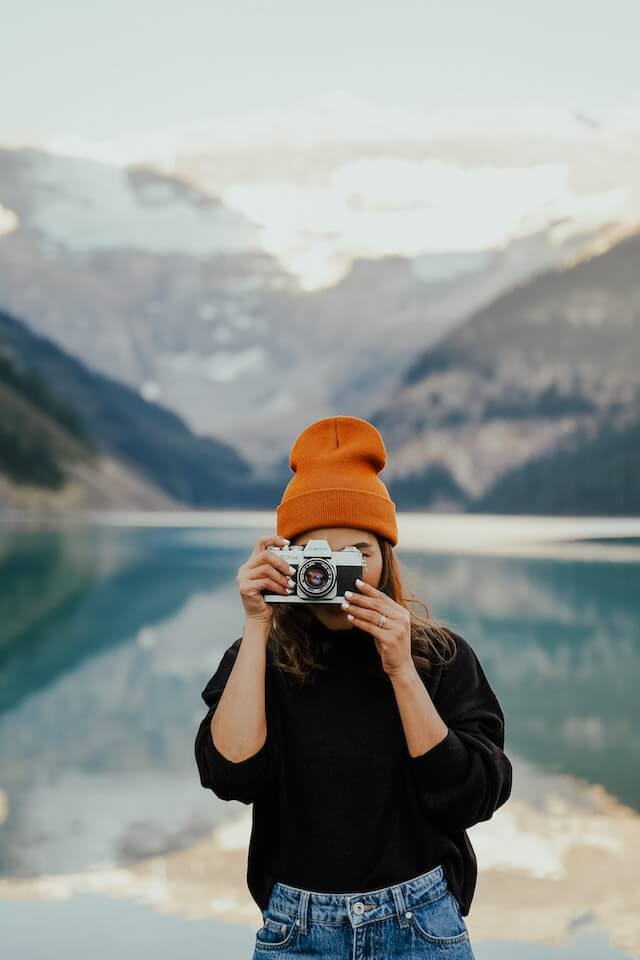

Combined Contour Image


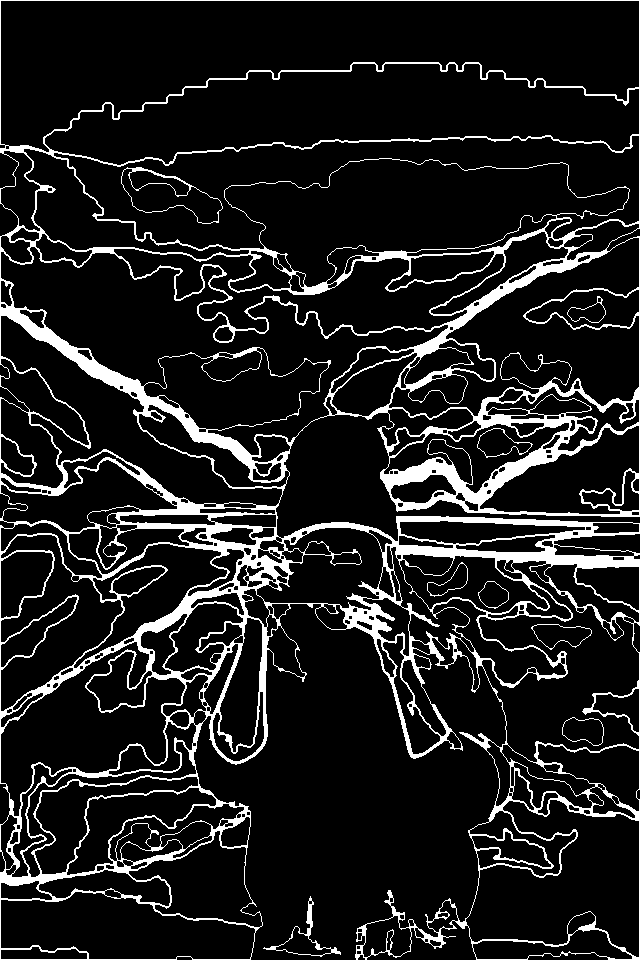

Cleaned Contours


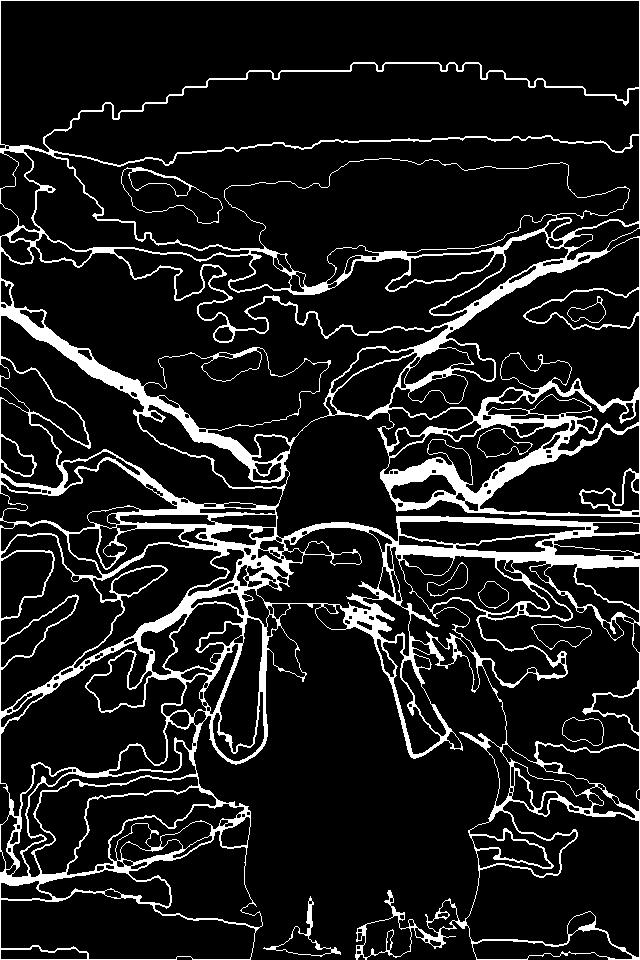

Line Drawing Image


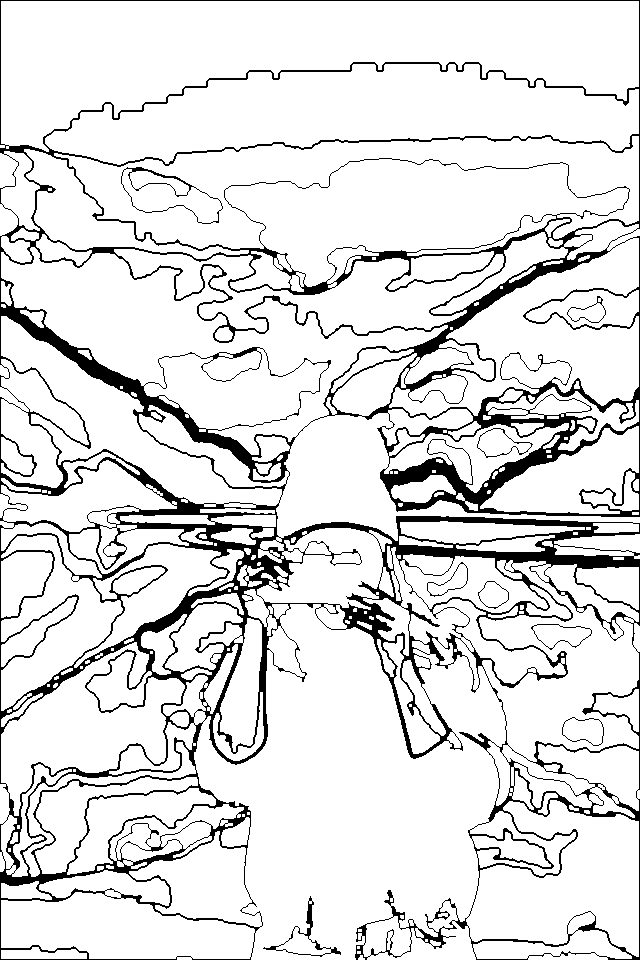

In [254]:
# Execute the above code

# Load image
image = load_image('/content/girl-with-camera.jpg')

# Detect contours
agg_contour_img = composite_contour_detection(image)

# Example usage:
cleaned_image = remove_double_lines(agg_contour_img)

line_drawing_image = cv2.bitwise_not(cleaned_image)


# Display output
print("Original Image")
cv2_imshow(image)
print("Combined Contour Image")
cv2_imshow(agg_contour_img.astype(np.uint8))
# Display cleaned image
print("Cleaned Contours")
cv2_imshow(cleaned_image.astype(np.uint8))

print("Line Drawing Image")
cv2_imshow(line_drawing_image.astype(np.uint8))


In [255]:
# Save png Image
output_path = 'apple_contours.png'
save_image_as_png(line_drawing_image, output_path)

In [256]:
# Saving in SVG format

output_path = 'output.svg'
save_image_array_as_svg(line_drawing_image, output_path, pixel_size=1)


In [257]:

# Loading usage
svg_path = 'output.svg'
root = read_svg_image(svg_path)
print(root.tag, root.attrib)

{http://www.w3.org/2000/svg}svg {'baseProfile': 'full', 'height': '960', 'version': '1.1', 'width': '640'}


In [258]:
# Scaling the SVG Image to 12 inch X 16 inch with 300 DPI
input_path = 'output.svg'
output_path = 'scaled_svg_image.svg'
width = 3600  # 12 inches x 300 DPI
height = 4800  # 16 inches x 300 DPI
scale_svg_image(input_path, output_path, width, height)

In [259]:
import os

path = '/content/scaled_svg_image.svg'

if os.path.exists(path):
    print(f"The path '{path}' exists.")
else:
    print(f"The path '{path}' does not exist.")

The path '/content/scaled_svg_image.svg' exists.


In [228]:
# Example usage
svg_path = path
scaled_img = svg_to_pil(svg_path)
# scaled_img.show()


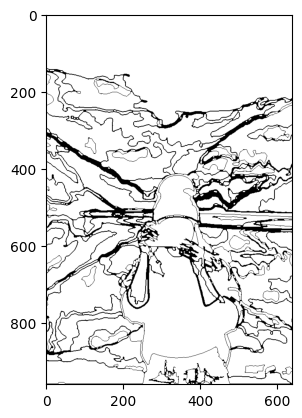

In [229]:
# # Example usage
# svg_path = path
# scaled_img = svg_to_pil(svg_path)

# Display image using matplotlib
plt.imshow(scaled_img)
plt.show()
